In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn import metrics

In [2]:
img_path='C:/School/ECE539/Project/R-CNN/Data/Images'
annot_path='C:/School/ECE539/Project/R-CNN/Data/Annotations'

# img_path='./Data/Images'
# annot_path='./Data/Annotations'

apple_1.jpg


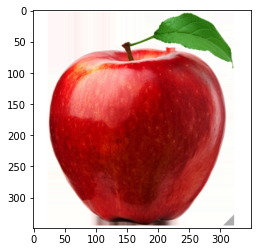

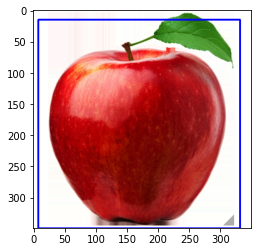

In [3]:
for e,i in enumerate(os.listdir(annot_path)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(img_path,filename))
        df = pd.read_csv(os.path.join(annot_path,i))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        break

In [4]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [5]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [6]:
train_images=[]
train_labels=[]
apple_count = 0
orange_count = 0
banana_count = 0
for e,i in enumerate(os.listdir(annot_path)):
    try:
        filename = i.split(".")[0]+".jpg"
        label_str = filename.split('_')[0]
        label_num = 0
        if label_str == 'apple':
            label_num = 1
        elif label_str == 'banana':
            label_num = 2   
        elif label_str == 'orange':
             label_num = 3
        elif label_str == 'mixed':
          continue
        image = cv2.imread(os.path.join(img_path,filename))
        df = pd.read_csv(os.path.join(annot_path,i))
        gtvalues=[]
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = image.copy()
        # plt.imshow(imout)
        # break
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter < 30:
                        if iou > 0.75:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(label_num)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    #print("inside")
                    flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [7]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

print(X_new.shape)
print(y_new.shape)

(12224, 224, 224, 3)
(12224,)


In [8]:
# TODO use resnet50 instead of vgg16
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [10]:
X= vggmodel.layers[-2].output

In [11]:
# predictions = Dense(2, activation="softmax")(X)
predictions = Dense(4, activation="softmax")(X)

In [12]:
model_final = Model(vggmodel.input, predictions)

In [13]:
opt = Adam(learning_rate=0.0001)

In [14]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [15]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [17]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [18]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(11001, 224, 224, 3) (1223, 224, 224, 3) (11001, 4) (1223, 4)


In [19]:
X_train, X_val , y_train, y_val = train_test_split(X_train,y_train,test_size=0.10)

In [20]:
#tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
vadata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
valdata = vadata.flow(x=X_val, y=y_val)

In [21]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [22]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [23]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 50, validation_data= valdata, validation_steps=2, callbacks=[checkpoint,early])


C:\Users\Xurso\AppData\Local\Temp\ipykernel_17360\1759319284.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 50, validation_data= valdata, validation_steps=2, callbacks=[checkpoint,early])


Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.9512 - accuracy: 0.7719
Epoch 1: val_loss improved from inf to 0.20930, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 92s 9s/step - loss: 0.9512 - accuracy: 0.7719 - val_loss: 0.2093 - val_accuracy: 0.9375
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.3207 - accuracy: 0.9125
Epoch 2: val_loss improved from 0.20930 to 0.11717, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 81s 8s/step - loss: 0.3207 - accuracy: 0.9125 - val_loss: 0.1172 - val_accuracy: 0.9531
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.1824 - accuracy: 0.9594
Epoch 3: val_loss did not improve from 0.11717
10/10 [==============================] - 66s 7s/step - loss: 0.1824 - accuracy: 0.9594 - val_loss: 0.2110 - val_accuracy: 0.9219
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 0.1787 - accuracy: 0.9406
Epoch 4: val_loss 

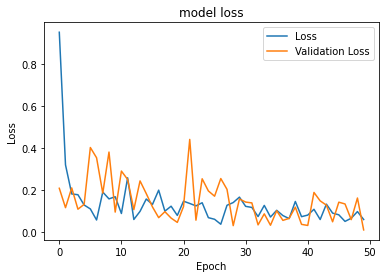

<Figure size 432x288 with 0 Axes>

In [24]:
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

1/1 [==============================] - 0s 420ms/step
Not a fruit


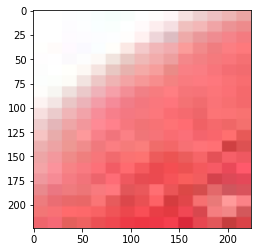

In [25]:
im = X_test[140]
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
img_class = max(out[0])
pred_label = list(out[0]).index(img_class)
if pred_label == 0:
    print("Not a fruit")
elif pred_label == 1:
    print('apple')
elif pred_label == 2:
    print("banana")
elif pred_label == 3:
    print('orange')
# if out[0][0] > out[0][1]:
#     print("Fruit")
# else:
#     print("Not Fruit")

In [26]:
# z=0
# for e,i in enumerate(os.listdir(img_path)):
  
#     if i.startswith("mixed_5"):
#         z += 1
#         img = cv2.imread(os.path.join(img_path,i))
#         ss.setBaseImage(img)
#         ss.switchToSelectiveSearchFast()
#         ssresults = ss.process()
#         imout = img.copy()
#         for e,result in enumerate(ssresults):
#             if e < 2000:
#                 x,y,w,h = result
#                 timage = imout[y:y+h,x:x+w]
#                 resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
#                 img = np.expand_dims(resized, axis=0)
#                 out= model_final.predict(img)
#                 if out[0][1] > 0.7 or  out[0][2] > 0.7 or  out[0][3] > 0.7:
#                     cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
#         plt.figure()
#         plt.imshow(cv2.cvtColor(imout, cv2.COLOR_BGR2RGB))

In [27]:
# You can visualize the results with a confusion matrix.
def plot_confusion_matrix(y_classified, y_true):
  # Compute confusion matrix
    c_mat = np.zeros((y_test.shape[1],y_test.shape[1]))
    for i in range(len(y_true)):
        c_mat[y_classified[i], y_true[i] ] += 1

    group_counts = ["{0:0.0f}".format(value) for value in c_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in c_mat.flatten()/np.sum(c_mat)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(c_mat.shape[0], c_mat.shape[1])

    plt.figure(figsize=(12,10))
    sn.heatmap(c_mat, annot=labels, fmt='', cmap='rocket_r')
    plt.title("Confusion Matrix")
    plt.ylabel('Output Class')
    plt.xlabel('Target Class')

39/39 [==============================] - 164s 4s/step - loss: 0.1027 - accuracy: 0.9697
Test loss: 0.10272945463657379
Test accuracy: 0.9697465300559998
39/39 [==============================] - 163s 4s/step
Confusion matrix: 
 [[789  15  12   5]
 [  0 156   0   0]
 [  2   2 123   0]
 [  1   0   0 118]]


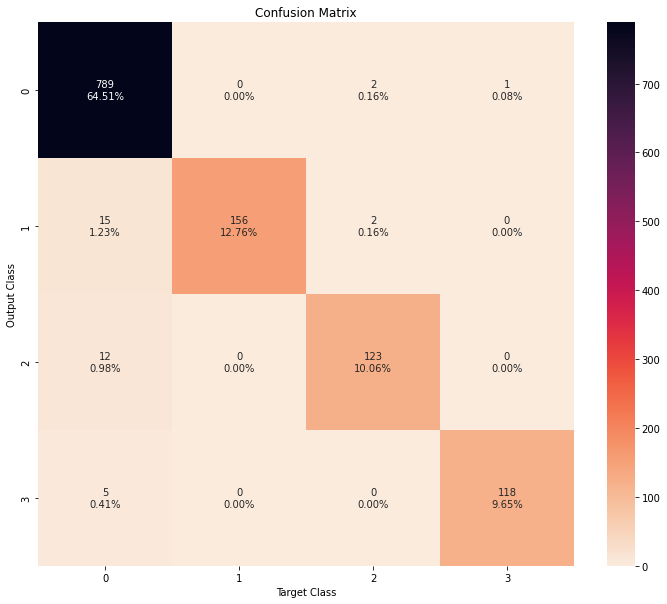

In [28]:
# Evaluate the trained model using keras built-in function
score = model_final.evaluate(X_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1]) 

y_classified = np.argmax(model_final.predict(X_test), axis=1)
y_true =  np.argmax(y_test, axis=1)
# Compute the confusion matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_classified))

# plot confusion matrix
plot_confusion_matrix(y_classified, y_true)

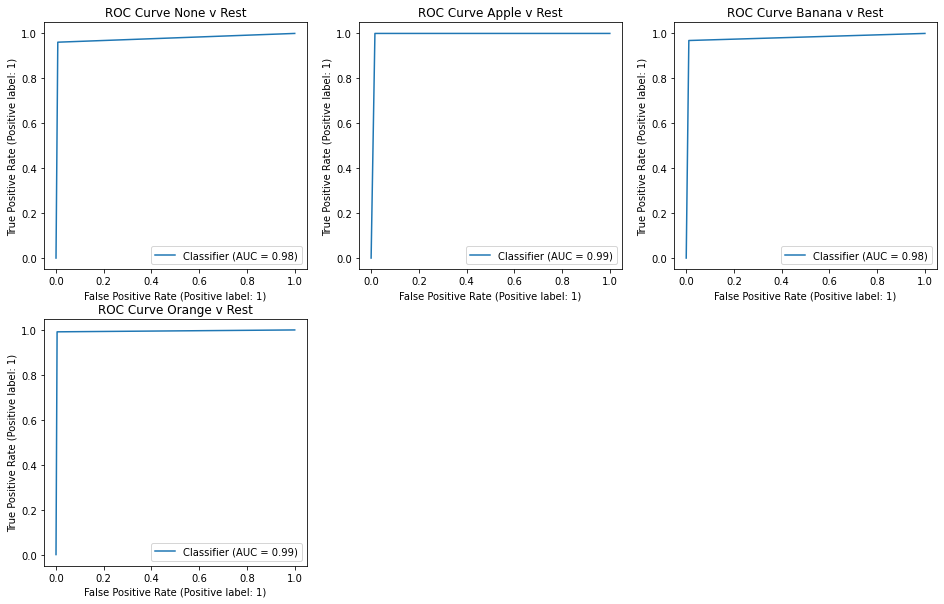

In [29]:
plt.figure(figsize = (16, 10))
classes = ['None','Apple', 'Banana', 'Orange']

for i in range(len(classes)):
    y_true_sub = np.array([int(y == i) for y in y_true])
    y_class_sub = np.array([int(y == i) for y in y_classified])
    
    roc_auc = metrics.roc_auc_score(y_true_sub,y_class_sub)

    ax = plt.subplot(2, 3, i+1)
    ax.set_title(classes[i])
    ax.legend([f"Class: {classes[i]}", "Rest"])
    ax.set_xlabel(f"P(x = {classes[i]})")

    # Calculates the ROC Coordinates and plots the ROC Curves
    fpr, tpr, threshold = metrics.roc_curve(y_true_sub, y_class_sub)
    #plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    RocCurveDisplay.from_predictions(y_true_sub, y_class_sub, ax = ax)
    ax.set_title(f"ROC Curve {classes[i]} v Rest")

In [30]:
metrics.matthews_corrcoef(y_true, y_classified, sample_weight=None)

0.9434846425235579